####**Exploring train dataset** 

In [1]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        n = 0
        for f in files:
            n = n+1
            if n>5:
                print('{}{}'.format(subindent, f),end = "  ...... \n")
                break
            print('{}{}'.format(subindent, f))
img_dir = 'img/virtual_img/'

list_files(img_dir)

/
TRAIN/
    FEMALE/
        resized_093_Female_Fluting001.png
        resized_046_Female_Fluting008.png
        resized_017_Female_Fluting007.png
        resized_085_Female_Fluting001.png
        resized_090_Female_Fluting007.png
        resized_017_Female_Fluting008.png  ...... 
    MALE/
        resized_102_Male_Fluting001.png
        resized_074_Male_Fluting003.png
        resized_007_Male_Fluting009.png
        resized_029_Male_Fluting007.png
        resized_087_Male_Fluting006.png
        resized_059_Male_Fluting002.png  ...... 
TEST/
    FEMALE/
        resized_019_Female_Fluting001.png
        resized_100_Female_Fluting003.png
        resized_020_Female_Fluting001.png
        resized_005_Female_Fluting002.png
        resized_066_Female_Fluting003.png
        resized_057_Female_Fluting006.png  ...... 
    MALE/
        resized_073_Male_Fluting009.png
        resized_098_Male_Fluting004.png
        resized_077_Male_Fluting007.png
        resized_013_Male_Fluting007.png
        re

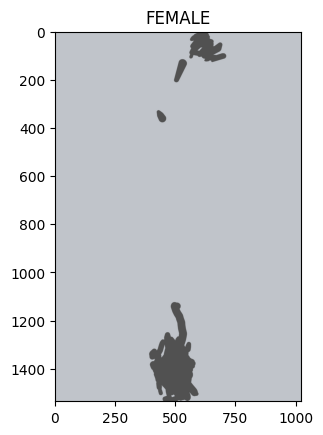

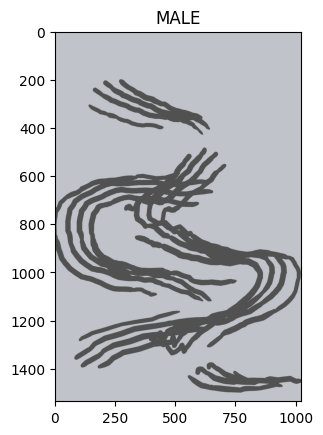

In [2]:
import cv2
import matplotlib.pyplot as plt

PATH_TRAIN =  os.path.join(img_dir, 'TRAIN')

PATH_TEST = os.path.join(img_dir, 'TEST')

normal_sample = cv2.imread(PATH_TRAIN+"/FEMALE/"+os.listdir(PATH_TRAIN+"/FEMALE")[3])
infected_sample = cv2.imread(PATH_TRAIN+"/MALE/"+os.listdir(PATH_TRAIN+"/MALE")[2])

plt.imshow(normal_sample)
plt.title("FEMALE")
plt.show()

plt.imshow(infected_sample)
plt.title("MALE")
plt.show()

The difference can be seen with different visualizations below

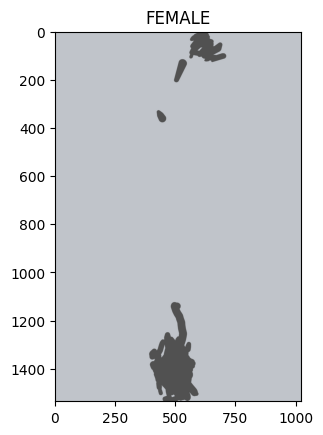

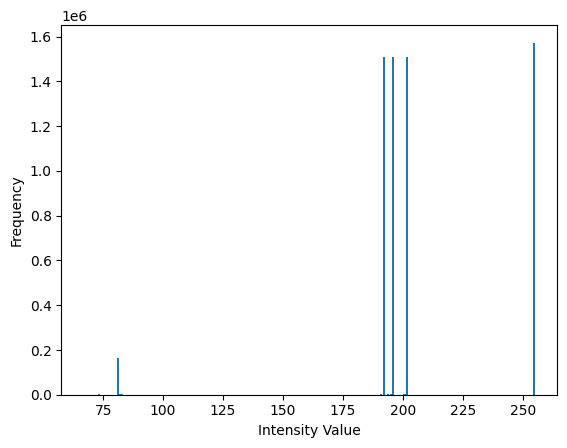

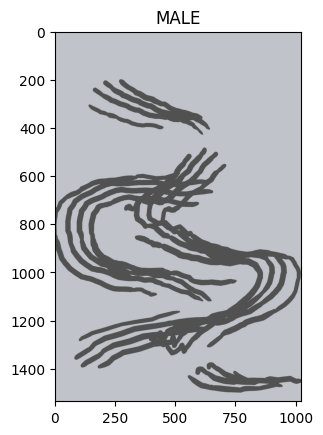

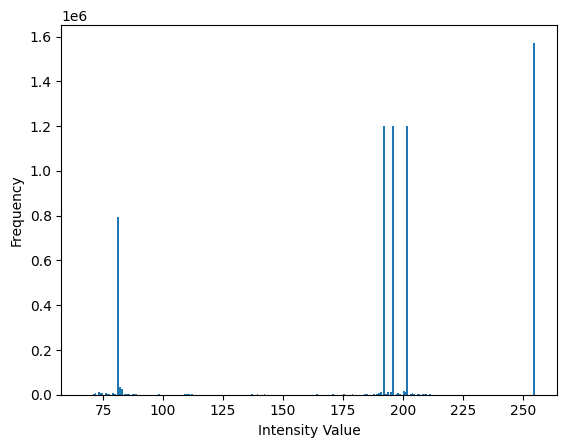

In [3]:
from skimage import io
import matplotlib.pyplot as plt

plt.imshow(normal_sample)
plt.title("FEMALE")
plt.show()

image = io.imread(PATH_TRAIN+"/FEMALE/"+os.listdir(PATH_TRAIN+"/FEMALE")[3])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

plt.imshow(infected_sample)
plt.title("MALE")
plt.show()

image = io.imread(PATH_TRAIN+"/MALE/"+os.listdir(PATH_TRAIN+"/MALE")[2])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

####**Initializing the data loader** 

vgg16 pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.<br />
The images have to be loaded in to a range of [0, 1] and then normalized using:
 #### mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] <br />
 
 We are applying augmentation like random rotation , horizontal and vertical flips to make sre the model doesn't overfit or learn the wrong features
 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import torchvision
from PIL import ImageFile
import matplotlib.pyplot as plt
import cv2
# ghf
ImageFile.LOAD_TRUNCATED_IMAGES = True # To prevent error during loading broken images

PATH_TRAIN =  os.path.join(img_dir, 'TRAIN')
PATH_TEST = os.path.join(img_dir, 'TEST')

# NOW TEST is a validation set.
EPOCHS = 200
BATCH_SIZE = 16
TOTAL_SIZE = len(os.listdir(PATH_TRAIN + "/FEMALE")) + len(
    os.listdir(PATH_TRAIN + "/MALE")
)
TOTAL_TEST_SIZE = len(os.listdir(PATH_TEST + "/FEMALE")) + len(
    os.listdir(PATH_TEST + "/MALE")
)
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
IMAGE_H, IMAGE_W = 384,384

print(TOTAL_SIZE , TOTAL_TEST_SIZE)

661 153


In [5]:
from torchvision.transforms import transforms

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([IMAGE_H, IMAGE_W]),                  # Resize input image to a uniform size
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),           # Randomly rotate the image between -10 and 10 degrees
    torchvision.transforms.RandomHorizontalFlip(p=0.5),                 # Random horizontal flip with a probability of 0.5
    torchvision.transforms.RandomVerticalFlip(p=0.5),                   # Random vertical flip with a probability of 0.5
    torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),    # Random perspective transformation
    torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur with randomly selected parameters
    torchvision.transforms.ToTensor(),                                  # Convert PIL Image or numpy.ndarray to tensor and normalize to [0, 1]
    torchvision.transforms.Normalize(                                   # Normalize to a standard normal distribution (Gaussian), which helps model convergence
        mean=[0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225])                                     # The mean and std values were calculated from a random sample of the dataset
])



# Intitalizing the train data loader and applying the transformations

train_dataset = torchvision.datasets.ImageFolder(root=PATH_TRAIN, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

# Intitalizing the test data loader

test_dataset = torchvision.datasets.ImageFolder(
    root=PATH_TEST, transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

In [6]:
from torchvision.models.efficientnet import EfficientNet_V2_S_Weights


model_ft = torchvision.models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT,
                                                progress=True)  # Initializing weight


num_ftrs = model_ft.classifier[1].in_features # Getting last layer's output features

model_ft.classifier[1] = nn.Linear(num_ftrs, 2) # Modify the last layer to output 2 classes

## **Initializing optimizers and loss function** <br/>
We will also specify the learning rate of the optimiser, here in this case it is set at 0.00001. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model_ft.parameters(), lr=0.00001
)  # lr should be kept low so that the pre-trained weights don't change easily

####**TESTING THE MODEL** 

In [8]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model_ft(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            for i in range(BATCH_SIZE):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )





In [9]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 75 INCORRECT: 69 TEST ACCURACY: 0.5208333333333334
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.5208333333333334 LOSS : 0.6956390937169393


####**TUNING THE MODEL (TRAINING)** 

In [ ]:
modal_save_path = 'Training_accuracy_plot/efficient_model_lr0.00001_epch200.pth'

avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []

loss_history = []
accuracy_history = []

best_acc = 0.0 

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model_ft(data)
        loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        for p in range(BATCH_SIZE):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    
    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model_ft.state_dict(), modal_save_path) # Saving our best model
        
    plt.plot(avg_train_accuracy_history , label = "Train")
    plt.plot(avg_test_accuracy_history , label = "Test")
    plt.title('ACCURACY PER EPOCH')
    plt.xlabel("EPOCHS")
    plt.ylabel("ACCURACY")
    plt.legend(loc="upper left")
    plt.savefig("Training_accuracy_plot/efficient_model_lr0.00001_during_training.png", dpi= 300)
    plt.clf()


#### Plotting the accuracy produced by model during training

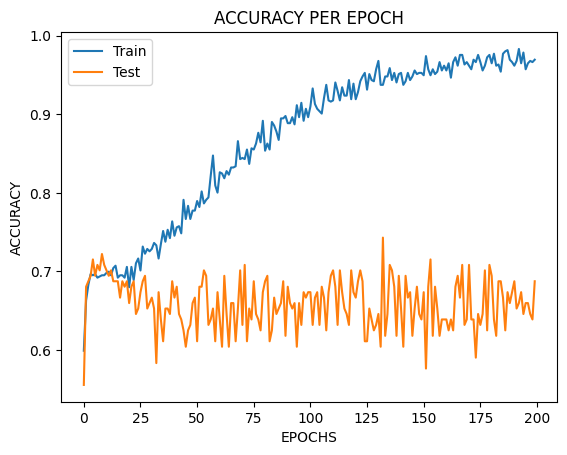

In [11]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend(loc="upper left")


In [12]:
print(new_best)

0.7430555555555556


In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.efficientnet import EfficientNet_V2_S_Weights

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model
model_ft = torchvision.models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)  # Adapt for binary classification

# Load trained weights
model_ft.load_state_dict(torch.load(modal_save_path))
model_ft.to(device)
model_ft.eval()  # Set to evaluation mode

# Preprocessing steps (must match training phase)
img_resized = 384
transform_test = transforms.Compose([
    transforms.Resize([img_resized, img_resized]),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
PATH_TEST =  'img/virtual_img_pp_split_by_gender_0.25reslution/TEST'

# 加载测试数据集
test_dataset = torchvision.datasets.ImageFolder(root=PATH_TEST, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=1, shuffle=False)

# 获取类别索引（0: FEMALE, 1: MALE）
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"类别索引: {idx_to_class}")


类别索引: {0: 'FEMALE', 1: 'MALE'}


In [15]:
from sklearn.metrics import roc_auc_score, f1_score

all_targets = []  # Ground truth labels
all_probs = []  # Predicted probabilities
all_preds = []  # Predicted classes

with torch.no_grad():  # Disable gradient calculation to save memory
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Send data to GPU
        output = model_ft(data)  # Perform inference
        probabilities = F.softmax(output, dim=1)[:, 1]  # Get probability for class 1 (Male)
        predicted = torch.argmax(output, dim=1)  # Get predicted class

        all_targets.extend(target.cpu().numpy())  # Ground truth labels
        all_probs.extend(probabilities.cpu().numpy())  # Predicted probabilities
        all_preds.extend(predicted.cpu().numpy())  # Predicted classes

# Calculate AUC (ROC-AUC Score)
auc_score = roc_auc_score(all_targets, all_probs)

# Calculate F1 Score
f1 = f1_score(all_targets, all_preds)

print(f"AUC Score: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


AUC Score: 0.7051
F1 Score: 0.5289
